In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
fname = '/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv'

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


# 0. Introduction

This notebook is a companion to my credit_default_risk notebook [(found here)](https://www.kaggle.com/code/rmiller415/credit-default-risk/edit). In the other notebook, I made a model that predicts default probability, but several of the data entries are missing the interest rate. In this notebook I will attempt to build a model that predicts the interest rate, which can then be fed into the first notebook to improve predictions.

In [34]:
data = pd.read_csv(fname)
df = data.copy()

int_rate_mask = df['loan_int_rate'].isna()
df['int_rate_mask'] = int_rate_mask
df[df['int_rate_mask']==True]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,int_rate_mask
39,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.42,N,4,True
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.38,Y,4,True
57,23,277000,OWN,3.0,PERSONAL,A,35000,NaN,0,0.13,N,4,True
59,24,12000,OWN,2.0,VENTURE,E,1750,NaN,0,0.15,Y,3,True
62,26,263000,MORTGAGE,0.0,EDUCATION,B,10000,NaN,1,0.04,N,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32547,53,4888,OWN,0.0,VENTURE,C,1400,NaN,1,0.29,Y,28,True
32552,65,45900,RENT,2.0,EDUCATION,C,10000,NaN,0,0.22,Y,19,True
32553,54,20000,RENT,2.0,MEDICAL,C,5000,NaN,0,0.25,N,28,True
32569,51,60000,MORTGAGE,1.0,PERSONAL,A,7500,NaN,0,0.13,N,23,True


# 1. Cursory Look at Data

## 1.1. Find Relationship Between 'loan_grade' and 'loan_int_rate'

In [4]:
#Load data
df = pd.read_csv(fname)

#Extract interest rates and find ranges.
loan_grade_feats = ['loan_grade','loan_int_rate','loan_intent']
loan_grade_sort = ['loan_grade','loan_intent']
maxs = df[loan_grade_feats].groupby(loan_grade_sort).max()
mins = df[loan_grade_feats].groupby(loan_grade_sort).min()

min_max = pd.concat((maxs,mins),axis=1)
min_max.columns = ['loan_int_rate'+f"_{i}" for i in ['max','min']]
min_max

loan_int_rate_max  loan_int_rate_min
loan_grade loan_intent                                            
A          DEBTCONSOLIDATION               9.63               5.42
           EDUCATION                       9.63               5.42
           HOMEIMPROVEMENT                 9.63               5.42
           MEDICAL                         9.63               5.42
           PERSONAL                        9.63               5.42
           VENTURE                         9.63               5.42
B          DEBTCONSOLIDATION              12.69               6.00
           EDUCATION                      12.69               6.00
           HOMEIMPROVEMENT                12.69               8.70
           MEDICAL                        12.69               6.00
           PERSONAL                       12.69               6.00
           VENTURE                        12.69               8.70
C          DEBTCONSOLIDATION              16.11               6.00
           EDUCATION                      15.96              10.28
           HOMEIMPROVEMENT                15.96              10.28
           MEDICAL                        16.11               6.00
           PERSONAL                       15.96              10.28
           VENTURE                        16.11              10.28
D          DEBTCONSOLIDATION              18.25               6.00
           EDUCATION                      18.25              11.86
           HOMEIMPROVEMENT                18.25              11.86
           MEDICAL                        18.25              11.86
           PERSONAL                       18.49               6.00
           VENTURE                        18.25              12.17
E          DEBTCONSOLIDATION              20.30              13.75
           EDUCATION                      20.20              13.75
           HOMEIMPROVEMENT                20.30              13.93
           MEDICAL                        20.69               6.00
           PERSONAL                       19.91              13.75
           VENTURE                        19.42              13.43
F          DEBTCONSOLIDATION              21.36              15.83
           EDUCATION                      21.74              15.01
           HOMEIMPROVEMENT                20.25              15.76
           MEDICAL                        21.74              15.01
           PERSONAL                       21.74              17.58
           VENTURE                        22.06              15.33
G          DEBTCONSOLIDATION              22.11              18.84
           EDUCATION                      21.21              18.84
           HOMEIMPROVEMENT                23.22              17.34
           MEDICAL                        21.64              18.84
           PERSONAL                       20.86              18.84
           VENTURE                        22.48              19.16

Above, the loan data is broken down by grade, intent, and the max/min interest rates are displayed above. I will use this data to determine the loan grade after predicting the loan rate.

## 1.2. Display First Lines of Data and Shape

In [5]:
print(df.shape)
df.head(10)

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


## 1.3. Check for NaNs

In [17]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Over 10% of the rows have a NaN value, I can use this to predict the loan interest rate and then feed it back into the model from the credit risk notebook.

## 1.4. Check for Class Imbalance in Target

Judging by the kernel density, it looks like there isn't a huge imbalance, but there are some outliers that may make things interesting. So, I tried using the standard scaler and performed a log1p and square root transform on both the unscaled and the scaled data, as pictured above. I think the square root transformed interest rate that has been scaled looks the least imbalanced, I will have to see how it performs as the target once I have selected my other features.

### Actionable Insights
1. Use the transformed features as targets and see which one is easier to predict.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Text(0.5, 1.0, 'Square Root Transformed Interest Rate Scaled')

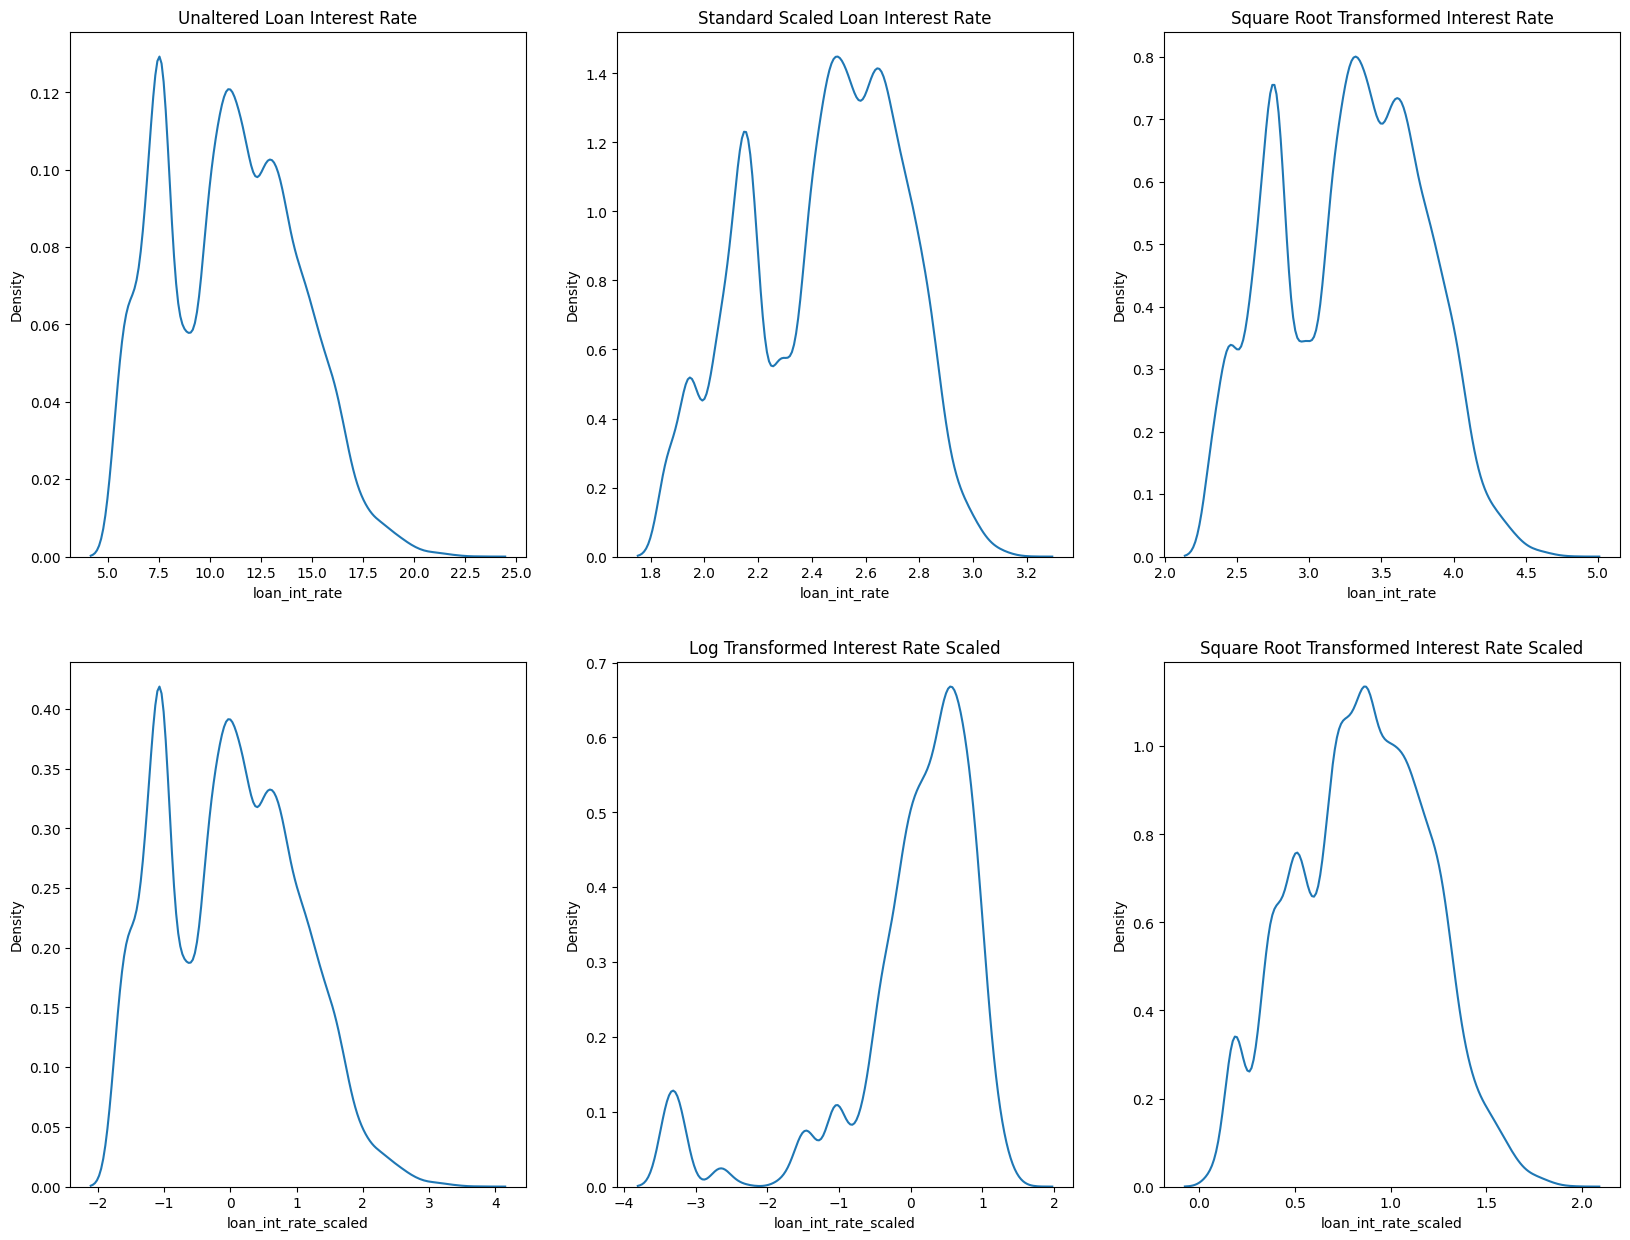

In [10]:
#Import packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Load data
data = pd.read_csv(fname)

df = data.copy()

df_ = df[df['loan_int_rate'].isna()==True] #Remove NaN values
df.drop(df_.index,inplace=True)

#Scale Features
df['loan_int_rate_scaled'] = StandardScaler().fit_transform(X=df[['loan_int_rate']])

#Plot data
fig,axs = plt.subplots(2,3,figsize=(20,15))
sns.kdeplot(df['loan_int_rate'],ax=axs[0,0])
sns.kdeplot(np.log1p(df['loan_int_rate']),ax=axs[0,1])
sns.kdeplot(np.sqrt(df['loan_int_rate']),ax=axs[0,2])
sns.kdeplot(df['loan_int_rate_scaled'],ax=axs[1,0])
sns.kdeplot(np.log1p(df['loan_int_rate_scaled']),ax=axs[1,1])
sns.kdeplot(np.sqrt(df['loan_int_rate_scaled']),ax=axs[1,2])

axs[0,0].set_title('Unaltered Loan Interest Rate')
axs[0,2].set_title('Square Root Transformed Interest Rate')
axs[0,1].set_title('Log Transformed Interest Rate')
axs[0,1].set_title('Standard Scaled Loan Interest Rate')
axs[1,1].set_title('Log Transformed Interest Rate Scaled')
axs[1,2].set_title('Square Root Transformed Interest Rate Scaled')

## 1.5. Check Feature Correlation with Target (Pearson)

<Axes: >

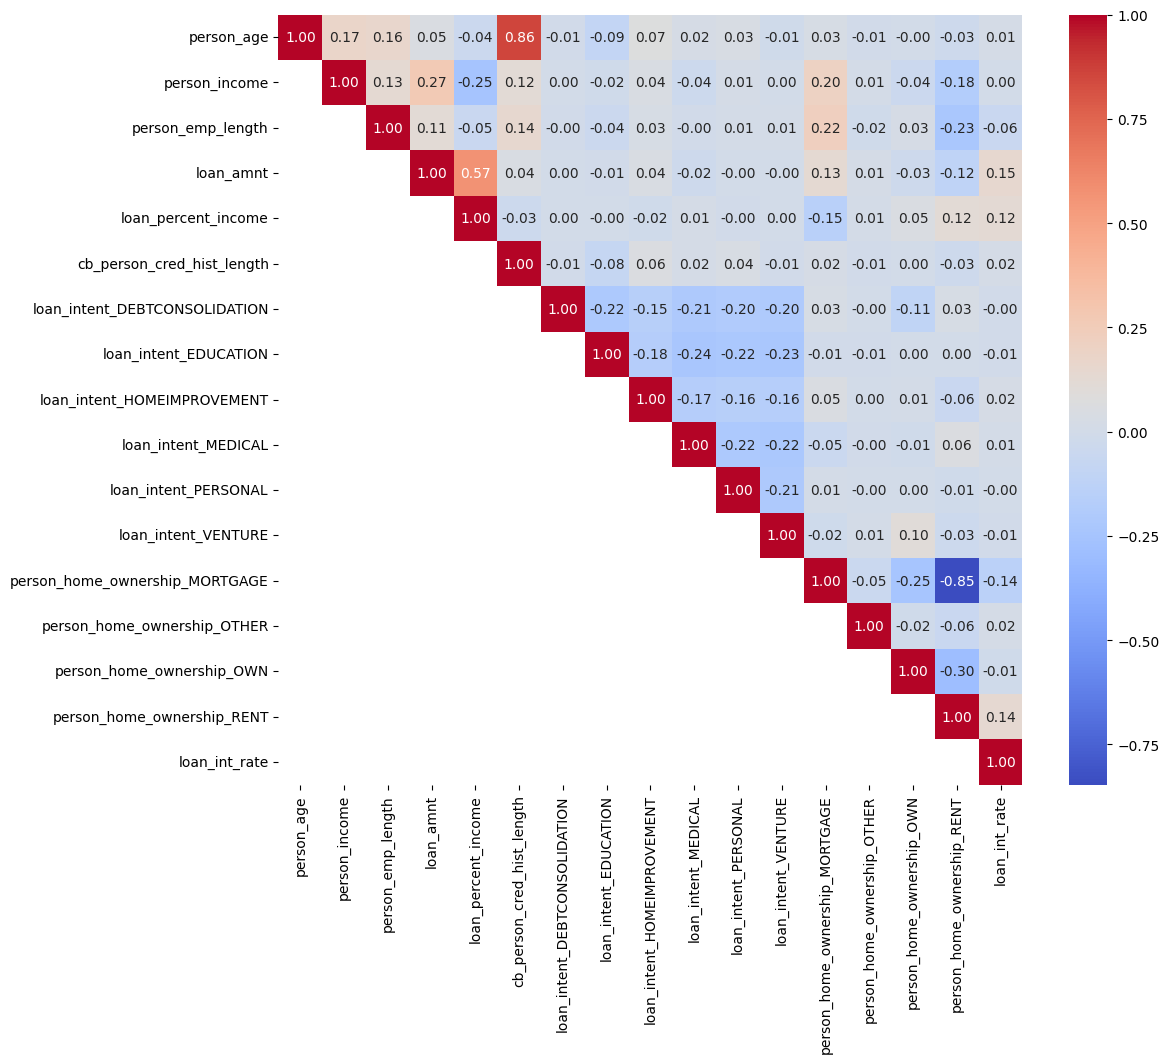

In [22]:
#Import packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

#Load data
data = pd.read_csv(fname)
df = data.copy()

##Encode features
#Call encoders
ord_enc = OrdinalEncoder()
oh_enc = OneHotEncoder()

#Define features to encode
oh_enc_list = ['loan_intent','person_home_ownership',]

#Encode features
oh_enc_data = oh_enc.fit_transform(df[oh_enc_list])
col_names = oh_enc.get_feature_names_out()
encoded_df = pd.DataFrame(oh_enc_data.toarray(),columns=col_names, index=df.index)
df = pd.concat((df,encoded_df),axis=1)

#Drop encoded feats
df.drop(oh_enc_list, axis=1, inplace=True)
df.drop(['loan_status','loan_grade'], axis=1, inplace=True)
target = df.pop('loan_int_rate')
df = pd.concat((df,target),axis=1)

#Get correlation matrix and mask
corr_mat = df.corr(numeric_only=True)
corr_mat_mask = np.tril(np.ones(corr_mat.shape,dtype='bool'),k=-1)

#Plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(corr_mat, mask=corr_mat_mask, annot=True, fmt='.2f', cmap='coolwarm',)

## 1.6. Check Feature Correlation with Target (Spearman)

<Axes: >

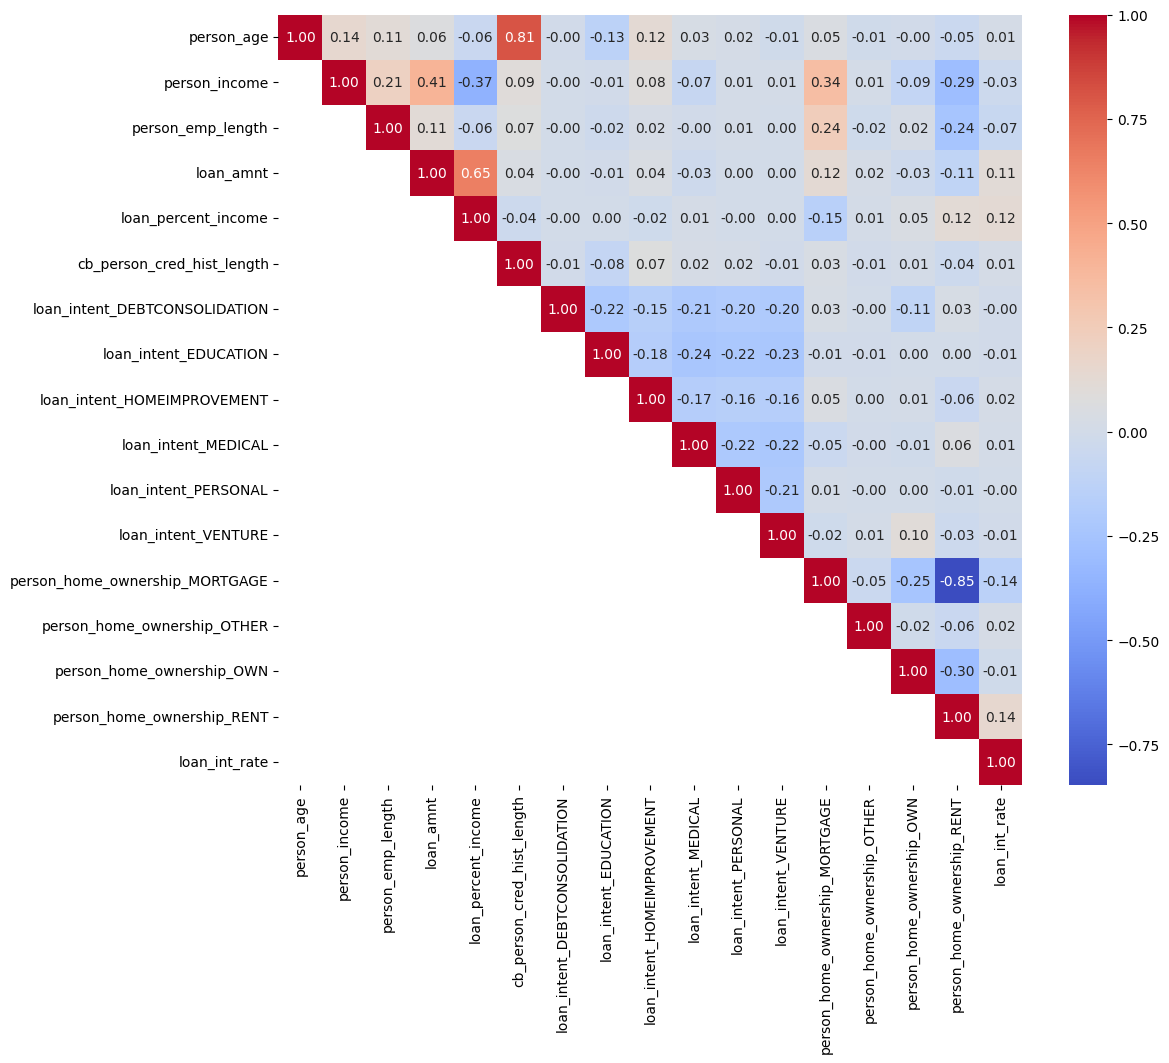

In [23]:
#Import packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

#Load data
data = pd.read_csv(fname)
df = data.copy()

##Encode features
#Call encoders
ord_enc = OrdinalEncoder()
oh_enc = OneHotEncoder()

#Define features to encode
oh_enc_list = ['loan_intent','person_home_ownership',]

#Encode features
oh_enc_data = oh_enc.fit_transform(df[oh_enc_list])
col_names = oh_enc.get_feature_names_out()
encoded_df = pd.DataFrame(oh_enc_data.toarray(),columns=col_names, index=df.index)
df = pd.concat((df,encoded_df),axis=1)

#Drop encoded feats
df.drop(oh_enc_list, axis=1, inplace=True)
df.drop(['loan_status','loan_grade'], axis=1, inplace=True)
target = df.pop('loan_int_rate')
df = pd.concat((df,target),axis=1)

#Get correlation matrix and mask
corr_mat = df.corr(numeric_only=True,method='spearman')
corr_mat_mask = np.tril(np.ones(corr_mat.shape,dtype='bool'),k=-1)

#Plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(corr_mat, mask=corr_mat_mask, annot=True, fmt='.2f', cmap='coolwarm',)

## 2.10. Feature Selection - person_emp_length vs cb_person_credit_length

In [3]:
data = pd.read_csv(fname)
parser = DataParser(data=data,params=params)
parser.automate()

X = parser.df.copy()
y = X.pop('loan_int_rate')

#Initialize storage
train_idxs,test_idxs = [],[]

#Split data
kfolds = KFold(n_splits=5)
for train,test in kfolds.split(X):
    train_idxs.append(train)
    test_idxs.append(test)

In [4]:
from sklearn.metrics import mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel

def feature_test(X,y,train_idxs,test_idxs,feature_list_A, feature_list_B,verbose=True):
    '''
    Extracts common features from two lists of features. Compares the model results from models trained with
    features A and common, features B and common, and features A vs features B using a t-test to determine if
    there is a statistically significant difference between the results of the two models.
    '''

    #Define variables
    max_iter=15000
    n_estimators=150
    
    #Initialize storage
    result = {}
    A_mae = []
    B_mae = []
    C_mae = []

    #Get features that are the intersection of list 1 and list 2
    common_feats = list(set(feature_list_A) & set(feature_list_B))
    
    for i,(train,test) in enumerate(zip(train_idxs,test_idxs)):
        if verbose == True:
            print(f"Current Iteration: {i+1} of {len(train_idxs)}")
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
    
        model_A = RandomForestRegressor(n_estimators=n_estimators)
        model_B = RandomForestRegressor(n_estimators=n_estimators)
        model_C = RandomForestRegressor(n_estimators=n_estimators)
    
        model_A.fit(X_train[feature_list_A],y_train)
        model_B.fit(X_train[feature_list_B],y_train)
        model_C.fit(X_train[common_feats],y_train)
    
        A_preds = model_A.predict(X_test[feature_list_A])
        B_preds = model_B.predict(X_test[feature_list_B])
        C_preds = model_C.predict(X_test[common_feats])
    
        A_mae.append(mean_absolute_error(y_test, A_preds))
        B_mae.append(mean_absolute_error(y_test, B_preds))
        C_mae.append(mean_absolute_error(y_test, C_preds))
    
    t_test_AC, p_val_AC = ttest_rel(A_mae, C_mae)
    t_test_BC, p_val_BC = ttest_rel(B_mae, C_mae)
    t_test_AB, p_val_AB = ttest_rel(A_mae, B_mae)
    
    result['AC'] = {'t_test':t_test_AC,'p_val':p_val_AC,'feats_A':feature_list_A,'feats_C':common_feats,}
    result['BC'] = {'t_test':t_test_BC,'p_val':p_val_BC,'feats_B':feature_list_B,'feats_C':common_feats,}
    result['AB'] = {'t_test':t_test_AB,'p_val':p_val_AB,'feats_A':feature_list_A,'feats_B':feature_list_B,}
    result['errors'] = {'mae_A':A_mae,'mae_B':B_mae,'mae_C':C_mae}

    if verbose == True:
        print(f"P-Value for Feature A and Common Features: {p_val_AC}")
        if p_val_AC < 0.05:
            print(f"Reject the null: models are statistically different.")
        else:
            print(f"Do not reject null: models are statistically similar.")

        print(f"P-Value for Feature B and Common Features: {p_val_BC}")
        if p_val_BC < 0.05:
            print(f"Reject the null: models are statistically different.")
        else:
            print(f"Do not reject null: models are statistically similar.")

        print(f"P-Value for Feature A and Feature B: {p_val_AB}")
        if p_val_AB < 0.05:
            print(f"Reject the null: models are statistically different.")
        else:
            print(f"Do not reject null: models are statistically similar.")
    return result

## 2.11 Feature Selection - log vs square root vs binned features.

In [2]:
#Import packages
from sklearn.preprocessing import OneHotEncoder,StandardScaler, OrdinalEncoder
from sklearn.model_selection import KFold

params = {
    'target':'loan_int_rate',
    'drop_rows':{
        'extract_target_nans':True,
    },
    'threshold_values':{
        'person_age':{
            'upper':100,
            'lower':18,
        },
        'person_emp_length':{
            'upper':100,
            'lower':1,
        },
    },
    'oh_encoding':{
        'feats':['loan_intent','person_home_ownership'],
    },
    'binary_encoding':{
        'cb_person_default_on_file':{
            'Y':1,
            'N':0,
        },
    },
    'sqrt_transform':{
        'feats':['person_emp_length','cb_person_cred_hist_length',],
    },
    'log_transform':{
        'feats':['loan_percent_income','person_income','person_emp_length','cb_person_cred_hist_length',],
    },
    'bin_data':{
        'feats':['person_emp_length','cb_person_cred_hist_length',],
        'method':'freedman_draconis',
        'edges':None,
    },
    'drop_columns':['loan_grade','loan_status','person_age'],
    'scale_feats':{
        'feats_to_scale':['loan_amnt','loan_int_rate',
                          'loan_percent_income_log_trans',
                          'person_income_log_trans',
                          'person_emp_length_log_trans',
                          'cb_person_cred_hist_length_log_trans',
                         ]
    }
}

class DataParser:
    def __init__(self,data,params):
        #Set self statements
        self.params = params
        self.data = data
        self.df = data.copy()
        self.cols_to_drop = []

    def automate(self):
        self.extract_target_nans()
        self.drop_nan_rows()
        self.threshold_data()
        self.oh_encoding()
        self.binary_encoding()
        self.log_transform()
        self.sqrt_transform()
        self.bin_data()
        self.drop_columns()

    def drop_nan_rows(self,extract=True):
        #Check if nan rows need to be extracted
        if extract == True:
            extract_target_nans = True
        else:
            extract_target_nans = self.params['drop_rows']['extract_target_nans']
            
        if extract_target_nans == True:
            self.extract_target_nans()

        #Drop rows with nan values
        nan_row_mask = self.df[self.df.isna().any(axis=1)==True]
        self.df.drop(nan_row_mask.index,inplace=True)

    def scale_feats(self,feats=None):
        if feats=None:
            feats_to_scale = self.params['scale_feats']['feats_to_scale']
        else:
            feats_to_scale = feats.copy()
            
        scaler = StandScaler()

    
    def drop_columns(self):
        drop_list = self.params['drop_columns']
        self.cols_to_drop = self.cols_to_drop + drop_list
        self.cols_to_drop = list(set(self.cols_to_drop))
        for col in self.cols_to_drop:
            self.df.drop(col,axis=1,inplace=True)

    def extract_target_nans(self):
        #Extract nan's in the column
        self.df_target_extracted = self.df[self.df['loan_int_rate'].isna()==True]
        self.df.drop(self.df_target_extracted.index,inplace=True)

    def threshold_data(self):
        #Get threshold values
        thresholds = self.params['threshold_values']
        
        for feat,threshold in thresholds.items():
            drop_thresh_rows = self.df[
            (self.df[feat]>=threshold['upper']) | (self.df[feat] <= threshold['lower'])
            ]
            self.df.drop(drop_thresh_rows.index,inplace=True)
            
        #Append columns to drop
        self.cols_to_drop = self.cols_to_drop + list(thresholds.keys())
        
    def oh_encoding(self):
        #Get features to encode
        oh_feats_to_encode = self.params['oh_encoding']['feats']

        #Initialize encoder and transform
        self.oh_encoder = OneHotEncoder()
        self.oh_encoded_data = self.oh_encoder.fit_transform(self.df[oh_feats_to_encode])

        #Extract feature names and generate extracted dataframe
        oh_feats_new_names = self.oh_encoder.get_feature_names_out()
        encoded_df = pd.DataFrame(
            self.oh_encoded_data.toarray(),
            columns=oh_feats_new_names,
            index=self.df.index,
        )

        #Concatenate dataframes
        self.df = pd.concat([self.df,encoded_df],axis=1)

        #Append column names
        self.cols_to_drop = self.cols_to_drop + oh_feats_to_encode


    def ord_encoding(self):
        ord_feats_to_encode = self.params['ord_encoding']['feats']
        drop_encoded_feats = self.params['ord_encoding']['drop_encoded_feats']
        ord_feats_encoded_name = [feat+'_ord_enc' for feat in ord_feats_to_encode]
        
        if ord_feats_to_encode:
            ord_encoder = OrdinalEncoder()
            ord_encoded_data = ord_encoder.fit_transform(self.df[ord_feats_to_encode])
            self.df[ord_feats_encoded_name] = ord_encoded_data

        self.cols_to_drop = self.cols_to_drop + ord_feats_to_encode

    def binary_encoding(self):
        #Initialize storage lists
        new_feats, old_feats = [],[]

        #Iterate through features,
        for feat,enc_dict in self.params['binary_encoding'].items():
            
            #Make new feature name
            new_feat_name = feat+'_binary_enc'
            
            #Append new/old feature names
            new_feats.append(new_feat_name)
            old_feats.append(feat)

            #Encode and append features to dataframe
            self.df[new_feat_name] = self.df[feat].apply(lambda x:enc_dict[x])

        #Append old features to drop list
        self.cols_to_drop = self.cols_to_drop + old_feats


    def sqrt_transform(self):
        #Extract features from parameter file and generate new feats
        sqrt_feats_to_transform = self.params['sqrt_transform']['feats']
        sqrt_feats_transformed_name = [feat +'_sqrt_trans' for feat in sqrt_feats_to_transform]

        #Iterate through feats, square root transform, and append to dataframe
        for old_feat,new_feat in zip(sqrt_feats_to_transform,sqrt_feats_transformed_name):
            self.df[new_feat] = np.sqrt(self.df[old_feat])

        #Append old features to drop list
        self.cols_to_drop = self.cols_to_drop + sqrt_feats_to_transform

    def log_transform(self):
        #Extract features from parameter file and generate new feats
        log_feats_to_transform = self.params['log_transform']['feats']
        log_feats_transformed_name = [feat+'_log_trans' for feat in log_feats_to_transform]

        #Iterate through features, log transform, and append to dataframe
        for old_feat,new_feat in zip(log_feats_to_transform,log_feats_transformed_name):
            self.df[new_feat] = np.sqrt(self.df[old_feat])

        #Append old features to drop list
        self.cols_to_drop = self.cols_to_drop + log_feats_to_transform

    def bin_data(self):
        #Define bin width finding functions
        def freedman_draconis(data):
            q3,q1 = np.percentile(data,[75,25])
            iqr = q3-q1
            n = len(data)
            return 2*iqr/n**(1/3)

        #Extract variables form parameter file
        feats_to_bin = self.params['bin_data']['feats']
        bin_method = self.params['bin_data']['method']

        #Generate new feature names
        binned_feat_name = [feat+'_binned' for feat in feats_to_bin]

        #Check and standardize bin_method input
        if (isinstance(bin_method,list)==True) | (isinstance(bin_method,tuple)==True):
            if len(bin_method) == len(feats_to_bin):
                pass
            else:
                raise ValueError(f"The length of bin_method and feats_to_bin must be the same.\nThey are currently bin_method: {len(bin_method)} and feats_to_bin: {len(feats_to_bin)}")
        #Check if bin_method is a string and in acceptable list of strings
        elif isinstance(bin_method,str):
            if bin_method in [
                'custom_bins',
                'freedman_draconis',
                'even_spaced',
            ]:
                #Generate list of repeated methods
                bin_method = [bin_method for feat in feats_to_bin]
            else:
                raise ValueError(f"The requested binning operation ({bin_method}) has not been implimented or is not recognized")
                
        for (method,old_feat,new_feat) in zip(bin_method,feats_to_bin,binned_feat_name):
            #Extract data
            df_ = self.df[old_feat].copy()
            df_min = df_.min()
            df_max = df_.max()

            ###Generate bins
            ##Using Freedman-Draconis Method
            if method == 'freedman_draconis':
                step_size = freedman_draconis(df_)
                bins = np.arange(df_min,df_max+step_size,step_size)

            ##Using custom defined bins
            #Bins must be located in params['bin_data']['custom_bins']
            elif method == 'custom_bins':
                try:
                    #Try to extract bins
                    bins = self.params['bin_data']['custom_bins'][feat]

                    #Check that bins have the same length
                    if len(bins) != len(feats_to_bin):
                        raise ValueError(f"The number of bins ({len(bins)}) does not match the number of features ({len(feats_to_bin)}).")
                
                #Raise exception is custom bins aren't located
                except:
                    raise KeyError('The binned data cannot be found in the parameter file.')

            ##Using N evenly spaced bins
            elif method == 'even_spaced':
                try:
                    #Try to extract number of bins (N) from parameter file
                    num_bins = self.params['bin_data']['num_bins'][feat]
                except:
                    raise KeyError('The number of bins cannot be found in the parameter file.')

                bins = np.linspace(df_min,df_max,num_bins)

            
            self.df[new_feat] = pd.cut(self.df[old_feat],bins=bins)


In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel

def feature_test(X,y,train_idxs,test_idxs,feature_list_A, feature_list_B,verbose=True):
    '''
    Extracts common features from two lists of features. Compares the model results from models trained with
    features A and common, features B and common, and features A vs features B using a t-test to determine if
    there is a statistically significant difference between the results of the two models.
    '''

    #Define variables
    max_iter=15000
    n_estimators=150
    
    #Initialize storage
    result = {}
    A_mae = []
    B_mae = []
    C_mae = []

    #Get features that are the intersection of list 1 and list 2
    common_feats = list(set(feature_list_A) & set(feature_list_B))
    
    for i,(train,test) in enumerate(zip(train_idxs,test_idxs)):
        if verbose == True:
            print(f"Current Iteration: {i+1} of {len(train_idxs)}")
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
    
        model_A = RandomForestRegressor(n_estimators=n_estimators)
        model_B = RandomForestRegressor(n_estimators=n_estimators)
        model_C = RandomForestRegressor(n_estimators=n_estimators)
    
        model_A.fit(X_train[feature_list_A],y_train)
        model_B.fit(X_train[feature_list_B],y_train)
        model_C.fit(X_train[common_feats],y_train)
    
        A_preds = model_A.predict(X_test[feature_list_A])
        B_preds = model_B.predict(X_test[feature_list_B])
        C_preds = model_C.predict(X_test[common_feats])
    
        A_mae.append(mean_absolute_error(y_test, A_preds))
        B_mae.append(mean_absolute_error(y_test, B_preds))
        C_mae.append(mean_absolute_error(y_test, C_preds))
    
    t_test_AC, p_val_AC = ttest_rel(A_mae, C_mae)
    t_test_BC, p_val_BC = ttest_rel(B_mae, C_mae)
    t_test_AB, p_val_AB = ttest_rel(A_mae, B_mae)
    
    result['AC'] = {'t_test':t_test_AC,'p_val':p_val_AC,'feats_A':feature_list_A,'feats_C':common_feats,}
    result['BC'] = {'t_test':t_test_BC,'p_val':p_val_BC,'feats_B':feature_list_B,'feats_C':common_feats,}
    result['AB'] = {'t_test':t_test_AB,'p_val':p_val_AB,'feats_A':feature_list_A,'feats_B':feature_list_B,}
    result['errors'] = {'mae_A':A_mae,'mae_B':B_mae,'mae_C':C_mae}

    if verbose == True:
        print(f"P-Value for Feature A and Common Features: {p_val_AC}")
        if p_val_AC < 0.05:
            print(f"Reject the null: models are statistically different.")
        else:
            print(f"Do not reject null: models are statistically similar.")

        print(f"P-Value for Feature B and Common Features: {p_val_BC}")
        if p_val_BC < 0.05:
            print(f"Reject the null: models are statistically different.")
        else:
            print(f"Do not reject null: models are statistically similar.")

        print(f"P-Value for Feature A and Feature B: {p_val_AB}")
        if p_val_AB < 0.05:
            print(f"Reject the null: models are statistically different.")
        else:
            print(f"Do not reject null: models are statistically similar.")
    return result

In [3]:
data = pd.read_csv(fname)
parser = DataParser(data=data,params=params)
parser.automate()

X = parser.df.copy()
y = X.pop('loan_int_rate')

#Initialize storage
train_idxs,test_idxs = [],[]

#Split data
kfolds = KFold(n_splits=5)
for train,test in kfolds.split(X):
    train_idxs.append(train)
    test_idxs.append(test)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

##Get list of feat name pairs (cred_hist_length_sqrt_trans,person_emp_length_sqrt_trans)
#Generate lists of new features
feat_base = ['cb_person_cred_hist_length','person_emp_length']
feat_extensions = ['_sqrt_trans','_log_trans','_binned']
feat_extensions_dict = dict(zip(feat_extensions,['sqrt','log','binned']))

#Generate list of new feature tuples to iterate through.
feats = [(feat_base[0]+ext,feat_base[1]+ext) for ext in feat_extensions]
base_feats = [
    'loan_amnt',
    'cb_person_default_on_file_binary_enc',
    'loan_intent_DEBTCONSOLIDATION','loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
    'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
    'person_home_ownership_OWN', 'person_home_ownership_RENT', 
    'loan_percent_income_log_trans',
    'person_income_log_trans',
]
params = {
    'n_estimators':[100,200,500],
    'max_depth':[None,10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'max_features':['sqrt','log2'],
}

results = {}
for extension in feat_extensions:
    current_feats = base_feats.copy()
    current_feats = current_feats + [feat+extension for feat in feat_base]
    estimator = RandomForestRegressor()
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        verbose=3
    )
    grid_search.fit(X[current_feats],y)
    
    results[feat_extensions_dict(extension)] = {
        'best_estimator':grid_search.best_estimator_,
        'best_score':grid_search.best_score_,
        'best_params':grid_search.best_params_,
        'cv_resuts':grid_search.cv_results_,
    }

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.251 total time=   3.0s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.245 total time=   2.9s


KeyboardInterrupt: 